# En este cuaderno crearemos un catálogo de las obras disponibles en la plataforma [Teatrix](https://www.teatrix.com/), analizaremos algunos de sus datos y finalmente extraeremos el listado en un archivo de Excel.

En primer lugar, importamos las librerías necesarias para obtener el código de la página y filtrarlo mediante expresiones regulares:

In [1]:
import requests
import re

Hacemos el pedido a la web. Si el valor de su estatus es igual a 200, quiere decir que hemos tenido éxito:

In [2]:
url = 'https://www.teatrix.com/'
request = requests.get(url)
request.status_code

200

A continuación obtenemos los nombres de las páginas que contienen cada una de las obras, ubicados en el texto luego de la expresión "video/".

In [3]:
pattern = 'video/(.+)">'
nombres = re.findall(pattern,request.text)
print(f'La página principal de Teatrix nos devuelve {len(nombres)} nombres de obras')

La página principal de Teatrix nos devuelve 446 nombres de obras


Cada nombre puede aparecer más de una vez en el código, por lo cual necesitamos eliminar los repetidos. Para esto convertimos nuestra lista en un set, estructura que no contiene más de una ocurrencia de cada objeto:

In [4]:
nombres = set(nombres)
print(f'Actualmente, Teatrix cuenta con {len(nombres)} obras en su catálogo.')

Actualmente, Teatrix cuenta con 178 obras en su catálogo.


Ahora creamos un diccionario con la expresión regular correspondiente a cada uno de los datos que queremos extraer:

In [5]:
obras_regex = {'titulo':'title">(.+)</h2','teatro':'origin">(.+)</span>',
               'anio':'date">(\d+)','sinopsis':'md">\s*(.+)',
               'duracion':'duration">(\d+)  min',
               'elenco':"person=\\'(.*?)\\'\srole=\s\\'(.*?)\\'\s"}

Entonces ya podemos crear una lista que contenga nombre, teatro, año, duración, elenco y el link al trailer de cada una de las obras. Es posible que la siguiente celda tarde unos cuantos segundos en ejecutarse, ya que debe recorrer página por página y filtrar los datos que queremos en cada una de ellas:

In [6]:
data = [] #Primero creamos la lista que iremos llenando con los datos de cada obra.
for i in nombres: #Iniciamos un bucle que itere el proceso en la página de cada obra.
  url_obra = f'{url}video/{i}' 
  obra_data = {} #Creamos un diccionario vacío cada vez que se inicia un ciclo.
  while len(obra_data) < 1: #Repetimos el ciclo hasta asegurarnos de que obtuvimos
  #datos, ya que puede suceder que a veces el request devuelva un objeto vacío. 
    html = requests.get(url_obra)
    for nombre, regex in obras_regex.items():
      dato = re.findall(regex, html.text)
      if dato: #Si el dato en cuestión es hallado, lo agregamos al diccionario.
        obra_data[nombre] = dato[0]
  obra_data['trailer'] = f'{url}ver/{i}' #El trailer podemos
  #agregarlo sin necesidad de recurrir a expresiones regulares.
  data.append(obra_data)

Vemos los primeros cinco elementos para comprobar que el proceso haya sido exitoso:

In [7]:
data[:5]

[{'anio': '2009',
  'duracion': '88',
  'elenco': ('Oscar Martínez', 'Autoría'),
  'sinopsis': '¿La escena es reflejo de la vida o viceversa? Este interrogante plantea la obra escrita, dirigida y protagonizada por Oscar Martínez, junto a Claudia Fontan. Un matrimonio de actores ensaya y confronta su realidad entre reproches, dolor, risa, ironía y sutil reflexión sobre las relaciones de pareja.</p>',
  'teatro': 'Buenos Aires',
  'titulo': 'PURA FICCIóN',
  'trailer': 'https://www.teatrix.com/ver/pura-ficcion'},
 {'anio': '2018',
  'duracion': '72',
  'elenco': ('Juan Leyrado', 'Actor'),
  'sinopsis': 'En su primer unipersonal, Juan Leyrado pone todo su talento al servicio del humor y las emociones.</p>',
  'teatro': 'Multiteatro',
  'titulo': 'EL ELOGIO DE LA RISA',
  'trailer': 'https://www.teatrix.com/ver/el-elogio-de-la-risa'},
 {'anio': '2013',
  'duracion': '146',
  'sinopsis': 'Karen y Lorene &nbsp;están en la cubierta del barco &nbsp;mientras  abandonan  Hawai .Recuerdan esos dí

Antes de seguir importamos la librería Pandas, la cual nos ayudará a manipular los datos:

In [8]:
import pandas as pd

Ahora sí, creamos nuestro catálogo y lo revisamos tomando una muestra al azar:

In [9]:
catalogo = pd.DataFrame(data)
print(catalogo.shape)
catalogo.sample(5)

(178, 7)


,titulo,teatro,anio,sinopsis,duracion,elenco,trailer
174,BRUJAS,Teatro Ateneo,1992,"Moria Casán, Graciela Dufau, Nora Cárpena, The...",102,NaN,https://www.teatrix.com/ver/brujas
36,TU CUNA FUE UN CONVENTILLO,Cuarentena,2020,Los cien años de uno de los sainetes criollos ...,54,"(Santiago Doria, Versión )",https://www.teatrix.com/ver/tu-cuna-fue-un-con...
83,COMO SI PASARA UN TREN,Teatro Picadero,2020,"La obra de Lorena Romanin deja, sin buscarlo, ...",80,NaN,https://www.teatrix.com/ver/como-si-pasara-un-...
107,ACALORADAS,Teatro Regina TSU,2018,"En Acaloradas, Patricia Echegoyen, María Ferna...",90,"(María Fernanda Callejón, Actriz )",https://www.teatrix.com/ver/acaloradas
104,TITA UNA VIDA EN TIEMPO DE TANGO,Teatro Metropolitan,2011,Nacha Guevara y un elenco de excelentes cantan...,107,"(Nacha Guevara, Autoría)",https://www.teatrix.com/ver/tita-una-vida-en-t...


¿Coincide la cantidad de nombres que extrajimos al principio con la longitud del DataFrame?

In [10]:
#Si esta celda no devuelve nada es porque las cantidades efectivamente coinciden.
assert len(nombres) == len(catalogo), 'Las cantidades no coinciden'

¿Cuáles son las obras más viejas del catálogo?

In [11]:
catalogo[catalogo['anio'] == catalogo['anio'].min()]

,titulo,teatro,anio,sinopsis,duracion,elenco,trailer
9,ALTA COMEDIA: SEIS PERSONAJES EN BUSCA DE UN A...,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",64,"(Mauricio Dayub, Actor)",https://www.teatrix.com/ver/alta-comedia-seis-...
35,ALTA COMEDIA: LA SANGRE DE LOS ORTIZ,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",61,"(Marcela Ferradás, Actriz )",https://www.teatrix.com/ver/alta-comedia-la-sa...
108,ALTA COMEDIA: HOY DIGO BASTA,Canal 9,1992,"Un episodio de Alta Comedia, el histórico cicl...",74,NaN,https://www.teatrix.com/ver/alta-comedia-hoy-d...
120,ALTA COMEDIA: PERSONA NO GRATA,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",54,NaN,https://www.teatrix.com/ver/alta-comedia-perso...
132,ALTA COMEDIA: SIN SALIDA,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",70,NaN,https://www.teatrix.com/ver/alta-comedia-sin-s...
174,BRUJAS,Teatro Ateneo,1992,"Moria Casán, Graciela Dufau, Nora Cárpena, The...",102,NaN,https://www.teatrix.com/ver/brujas


¿De qué años son la mayoría de las obras?

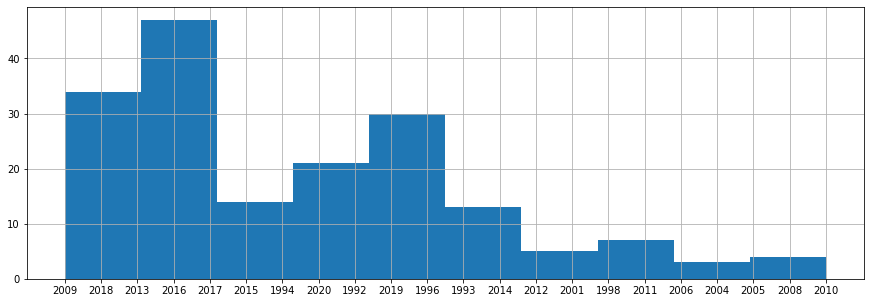

In [12]:
catalogo['anio'].hist(figsize=(15,5));

Ahora crearemos otro DataFrame para analizar la duración de las obras, eliminando los valores nulos, convirtiendo los minutos en datos operables y descartando aquellos que resulten anómalos:

In [13]:
df_dur = catalogo.dropna(subset=['duracion'])
df_dur.shape

(175, 7)

In [14]:
df_dur['duracion'] = df_dur['duracion'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
#Descartamos las obras que duren menos de 20 minutos, cifra arbitraria que tomamos
#como indicadora de datos anómalos:
df_dur = df_dur[df_dur['duracion'] > 20] 

¿Cuál es la obra más corta?

In [16]:
df_dur[df_dur['duracion'] == df_dur['duracion'].min()]

,titulo,teatro,anio,sinopsis,duracion,elenco,trailer
144,ISABEL DE GUEVARA,Centro cultural 25 de mayo,2018,Una obra de la prestigiosa Alicia Muño...,41,"(Mónica Villa, Actriz )",https://www.teatrix.com/ver/isabel-de-guevara


¿Y la más larga?

In [17]:
df_dur[df_dur['duracion'] == df_dur['duracion'].max()]

,titulo,teatro,anio,sinopsis,duracion,elenco,trailer
29,"ESQUIZOPEñA, INTIMIDAD RIOPLATENSE",Paseo La Plaza,2015,"El inolvidable Fernando Peña, trasgresor y cre...",172,NaN,https://www.teatrix.com/ver/esquizopena-intimi...


¿Cuál es el promedio de duración de las obras?

In [18]:
prom_dur = df_dur['duracion'].mean()
print(f'El promedio de duración de las obras es de {round(prom_dur)} minutos.')

El promedio de duración de las obras es de 88 minutos.


¿Cómo se distribuyen las obras según su duración?

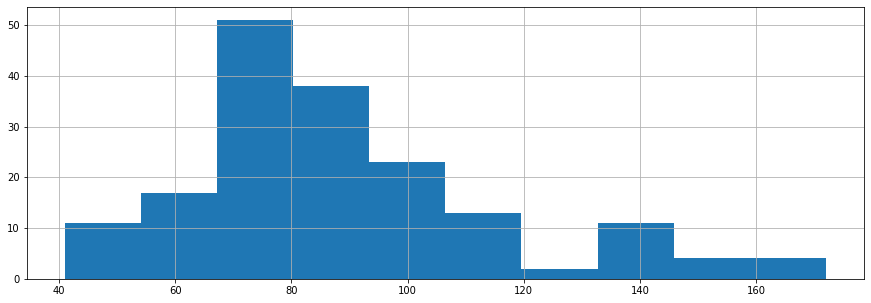

In [19]:
df_dur['duracion'].hist(figsize=(15,5));

Para finalizar, creamos un archivo de Excel con nuestro catálogo:

In [20]:
catalogo.to_excel('catalogo_teatrix.xlsx')